Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = r'C:\Users\aermo\train.csv'
TEST_DATASET_PATH = r'C:\Users\aermo\test.csv'

Загружаем данные

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [7]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [10]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


Меняем тип данных

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype('int64')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int64')

# EDA

Целевая переменная

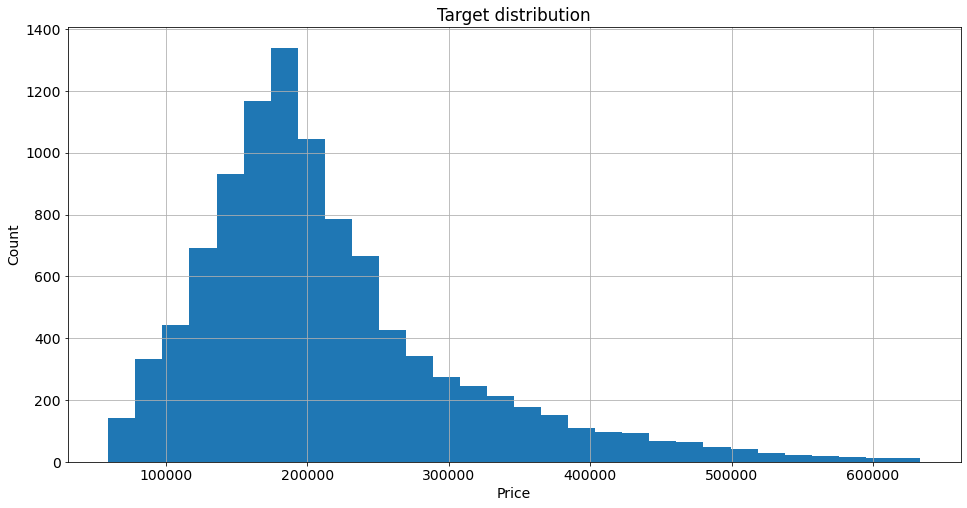

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#Основная масса домов находится в интервале стоимости 120 000 - 250 000. Далее чем дороже дом, тем меньше количество таких домов

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


 #Видим пропуски в LifeSquare и Healthcare_1. Очень маленькое min значение Square. 

Номинативные переменные

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
207      1
209      1
117      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#У Ecology_2, Ecology_3, Shops_2 только 2 значения. Можем перевести в бинарный признак

# Обработка пропусков

In [19]:
train_df.isna().sum()
#Ещё раз проверяем где есть пропуски

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [20]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,1.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,1.0
9,79.867477,75.085125,1.0


LifeSquare пропуски

In [21]:
# Найдём среднюю площадьдома, вне LifeSquare и KitchenSquare
condition = ((~train_df['LifeSquare'].isna())) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
sq = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - train_df.loc[condition, 'LifeSquare']
sq.mean()

10.451377119738071

In [22]:
#Создадим признак LifeSquare_nan, который будет указывать, что в LifeSquare были пропуски
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - sq
#В пропуски подставим значение общей площади минус значение площади кухни, минус 10

Healthcare_1 пропуски

In [23]:
train_df['Healthcare_1'].head(10)

0       NaN
1    1183.0
2     240.0
3       NaN
4       NaN
5    2078.0
6      80.0
7     176.0
8       NaN
9     540.0
Name: Healthcare_1, dtype: float64

In [24]:
train_df[['DistrictId', 'Healthcare_1', 'Floor']].head(10)

,DistrictId,Healthcare_1,Floor
0,27,NaN,4
1,22,1183.0,7
2,1,240.0,2
3,1,NaN,10
4,94,NaN,16
5,99,2078.0,9
6,44,80.0,1
7,59,176.0,8
8,1,NaN,12
9,6,540.0,3


In [25]:
# связи с другими признаками не нашли, удаляем
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [26]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
0,11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,0,0,B,305018.871089,1
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,B,30,6207,1,1,0,B,177734.553407,0
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,B,33,5261,0,3,1,B,282078.720850,0
3,2352,1,1,40.409907,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,0,1,B,168106.007630,1
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,B,33,8667,2,0,6,B,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090728,33.272626,6.0,3,12,1981,0.300323,B,B,52,10311,6,1,9,B,119367.455796,0
9996,16265,27,2,64.307684,37.038420,9.0,13,0,1977,0.072158,B,B,2,629,1,0,0,A,199715.148807,0
9997,2795,178,1,29.648057,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,1,5,B,165953.912580,0
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,B,B,47,8004,3,3,5,B,171842.411855,0


# Обработка выбросов

Rooms

In [27]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

#Очень мало домов с количеством комнат больше 5, есть дома без комнат. Возможно это выбросы

In [28]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
# создадим доп. признак 'Rooms_outlier', который будет указывать на возможные выбросы.

In [29]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier
0,11809,27,3,115.027311,NaN,10.0,4,10,2014,0.075424,...,B,11,3097,0,0,0,B,305018.871089,1,0
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,B,30,6207,1,1,0,B,177734.553407,0,0
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,B,33,5261,0,3,1,B,282078.720850,0,0
3,2352,1,1,40.409907,NaN,1.0,10,22,1977,0.007122,...,B,1,264,0,0,1,B,168106.007630,1,0
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,B,33,8667,2,0,6,B,343995.102962,0,0


In [30]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
# Изменим значения предполагаемых выбросов, где было 0 комнат, поставим 1. Где было больше 5 комнат, подставим значения медианы.
# Признак Rooms_outlier со значением 1, будет указывать на изменённые данные.

In [31]:
train_df['Rooms'].value_counts()

2    3884
1    3713
3    2235
4     150
5      18
Name: Rooms, dtype: int64

KitchenSquare

In [32]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [33]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [34]:
#Отредактируем выбросы в KitchenSquare
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

LifeSquare

In [35]:
train_df['LifeSquare'].value_counts()

28.003539    1
19.224066    1
21.613298    1
25.688943    1
44.662105    1
            ..
37.980219    1
17.130385    1
33.273700    1
28.313300    1
28.421652    1
Name: LifeSquare, Length: 7887, dtype: int64

In [36]:
train_df['LifeSquare'].quantile(.975), train_df['LifeSquare'].quantile(.025)

(80.74810407514713, 5.914129735023812)

In [37]:
train_df.loc[train_df['LifeSquare']<15]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier
26,8553,88,3,83.262530,4.769174,3.0,13,1,1977,0.127376,...,B,43,8429,3,3,9,B,410883.892020,0,0
119,5112,6,2,63.591740,0.795539,10.0,17,17,2014,0.243205,...,B,5,1564,0,0,0,B,174741.998061,0,0
161,6782,45,1,2.954309,5.257278,3.0,3,1,1977,0.195781,...,B,23,5212,6,3,2,B,438005.182323,0,0
212,1182,27,1,38.936986,3.064320,3.0,18,19,2017,0.211401,...,B,9,1892,0,0,1,B,93560.789553,0,0
227,3746,62,1,46.722042,1.944446,3.0,11,12,2018,0.072158,...,B,2,629,1,0,0,A,133721.121715,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,13523,23,1,52.787090,5.600609,3.0,7,1,2015,0.014073,...,B,2,475,0,0,0,B,104160.492175,0,0
9915,8998,20,1,30.082090,12.125029,7.0,9,9,1976,0.019509,...,B,37,7687,11,5,5,B,186537.391208,0,0
9938,2913,34,4,94.888593,2.637095,3.0,4,1,2018,0.069753,...,B,53,13670,4,1,11,B,346949.506507,0,0
9982,10268,27,1,36.112393,1.855415,3.0,9,16,1977,0.211401,...,B,9,1892,0,0,1,B,94881.691800,0,0


In [38]:
#Отредактируем выбросы в LifeSquare
condition = (train_df['LifeSquare'].isna()) \
             | (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975))
        
train_df.loc[condition, 'LifeSquare'] = train_df['LifeSquare'].median()

train_df.loc[train_df['LifeSquare'] < 15, 'LifeSquare'] = 15

Square

In [39]:
#Введём дополнительный признак 'Square_outlier', который будет указывать на редактирование данных в 'Square'
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']), 'Square_outlier'] = 1

In [40]:
train_df.loc[train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Square_outlier
8,9951,1,1,46.887892,44.628132,3.0,12,20,1977,0.007122,...,1,264,0,0,1,B,160400.401732,0,0,1
19,367,45,1,42.367289,40.012529,3.0,16,14,2015,0.195781,...,23,5212,6,3,2,B,250466.980777,0,0,1
33,847,74,2,73.314975,74.131261,3.0,7,6,1977,0.075779,...,6,1437,3,0,2,B,254005.381863,0,0,1
34,7757,27,2,58.783661,55.441256,11.0,13,12,1977,0.011654,...,4,915,0,0,0,B,138396.984612,0,0,1
37,1699,9,1,78.936164,76.746654,3.0,8,7,1977,0.161532,...,25,5648,1,2,4,B,226206.962435,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9947,8062,6,1,41.606714,42.249308,3.0,20,25,2017,0.243205,...,5,1564,0,0,0,B,137389.035128,0,0,1
9954,2241,6,2,55.789899,52.956655,3.0,14,17,2014,0.243205,...,5,1564,0,0,0,B,172267.847132,0,0,1
9962,14175,14,1,42.029175,44.682167,10.0,4,4,2018,0.238617,...,26,3889,6,3,6,B,87556.385617,0,0,1
9979,2201,6,1,40.043234,41.984322,3.0,3,17,2014,0.243205,...,5,1564,0,0,0,B,134888.083598,0,0,1


In [41]:
#Square не может быть меньше суммы LifeSquare и KitchenSquare, поэтому редактируем данный признак
train_df.loc[train_df['Square']<train_df['LifeSquare']+train_df['KitchenSquare'], 'Square'] \
= train_df['LifeSquare']+train_df['KitchenSquare']+sq

In [42]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Square_outlier
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,...,11,3097,0,0,0,B,305018.871089,1,0,0
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,30,6207,1,1,0,B,177734.553407,0,0,0
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,33,5261,0,3,1,B,282078.720850,0,0,0
3,2352,1,1,40.409907,32.781260,3.0,10,22,1977,0.007122,...,1,264,0,0,1,B,168106.007630,1,0,0
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,33,8667,2,0,6,B,343995.102962,0,0,0
5,5804,99,3,62.528465,47.103833,6.0,9,9,1972,0.012339,...,35,5776,1,2,4,B,161044.944138,0,0,0
6,8864,44,1,33.938750,21.772930,9.0,1,12,1968,0.232205,...,24,4860,1,0,3,B,142402.739272,0,0,0
7,13072,59,2,50.391814,32.893256,8.0,8,17,1986,0.019509,...,37,7687,11,5,5,B,326174.175191,0,0,0
8,9951,1,1,48.887892,44.628132,3.0,12,20,1977,0.007122,...,1,264,0,0,1,B,160400.401732,0,0,1
9,8094,6,3,79.867477,75.085125,3.0,3,17,2014,0.243205,...,5,1564,0,0,0,B,194756.023945,0,0,0


HouseFloor, Floor

In [43]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int64)

In [44]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [45]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [46]:
#Добавляем новый признак 'HouseFloor_outlier', который будет указывать на редактирование данных в 'HouseFloor'
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [47]:
#Нулевые значения HouseFloor меняем на медиану
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [48]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [49]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [50]:
#Для домов, где этаж больше общей этажности, поменяем значение этажа на случайное, в пределах этажности дома
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [51]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

HouseYear

In [52]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [53]:
#Для домов с годом постройки больше 2020 г., поставим 2020 г.
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [54]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.life_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.life_square_quantile = X['LifeSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - sq
        
        condition = (X['LifeSquare'].isna()) \
             | (X['LifeSquare'] > self.life_square_quantile)
        
        X.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']

        X.loc[X['LifeSquare'] < 15, 'LifeSquare'] = 15
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < X['LifeSquare'] + X['KitchenSquare']), 'Square_outlier'] = 1
        
        X.loc[X['Square'] < X['LifeSquare'] + X['KitchenSquare'], 'Square'] = X['LifeSquare'] + X['KitchenSquare'] + sq
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = ((~X['LifeSquare'].isna())) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        
        X.fillna(self.medians, inplace=True)
        
        
        
        return X

# Построение новых признаков

Dummies

In [55]:
##У Ecology_2, Ecology_3, Shops_2 только 2 значения. Переводим в бинарный признак
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

DistrictSize, IsDistrictLarge

In [56]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Square_outlier,HouseFloor_outlier
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,...,3097,0,0,0,1,305018.871089,1,0,0,0
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,0
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,0
3,2352,1,1,40.409907,32.781260,3.0,10,22,1977,0.007122,...,264,0,0,1,1,168106.007630,1,0,0,0
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090728,33.272626,6.0,3,12,1981,0.300323,...,10311,6,1,9,1,119367.455796,0,0,0,0
9996,16265,27,2,64.307684,37.038420,9.0,13,13,1977,0.072158,...,629,1,0,0,0,199715.148807,0,0,0,1
9997,2795,178,1,29.648057,16.555363,5.0,3,5,1958,0.460556,...,4386,14,1,5,1,165953.912580,0,0,0,0
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,...,8004,3,3,5,1,171842.411855,0,0,0,0


In [57]:
#Посмотрим количество домов в каждом районе с помощью признака district_size
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,205,1
201,207,1
202,209,1
203,117,1


In [58]:
#Добавим DistrictSize в train_df
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Square_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,...,0,0,0,1,305018.871089,1,0,0,0,851
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,1,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1,40.409907,32.781260,3.0,10,22,1977,0.007122,...,0,0,1,1,168106.007630,1,0,0,0,652
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,2,0,6,1,343995.102962,0,0,0,0,89


In [59]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [60]:
# Добавим признак IsDistrictLarge, указывающий на районы с количеством домов больше 100
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

MedPriceByDistrict

In [61]:
#Посмотрим среднюю стоимость домов группирую данные по районам и количеству комнат
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.434052
1,0,2,176210.812334
2,0,3,300610.359425
3,1,1,146735.671740
4,1,2,202666.310126


In [62]:
#Добавим MedPriceByDistrict в train_df
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Square_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,...,0,1,305018.871089,1,0,0,0,851,1,213530.788443
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,0,1,177734.553407,0,0,0,0,78,0,146032.829834
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,1,244005.272380
3,2352,1,1,40.409907,32.781260,3.0,10,22,1977,0.007122,...,1,1,168106.007630,1,0,0,0,652,1,146735.671740
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,6,1,343995.102962,0,0,0,0,89,0,201584.441255


MedPriceByFloorYear

In [63]:
#Добавляем функцию для создания категорий в зависимости от этажа
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 6), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 6) & (X['Floor'] <= 11), 'floor_cat'] = 3
    X.loc[X['Floor'] > 11, 'floor_cat'] = 4

    return X

def floor_to_cat_pandas(X):
    bins = [0, 3, 6, 11, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


#Добавляем функцию для создания категорий в зависимости от года постройки
def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [64]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [65]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [66]:
#Добавим новые признаки year_cat и floor_cat
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,LifeSquare_nan,Rooms_outlier,Square_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,...,305018.871089,1,0,0,0,851,1,213530.788443,6,2
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,177734.553407,0,0,0,0,78,0,146032.829834,3,3
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,282078.720850,0,0,0,0,652,1,244005.272380,4,1
3,2352,1,1,40.409907,32.781260,3.0,10,22,1977,0.007122,...,168106.007630,1,0,0,0,652,1,146735.671740,3,3
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,343995.102962,0,0,0,0,89,0,201584.441255,3,4


In [67]:
#Создадим новый признак, средняя стоимость дома в зависимости от категории этажа и года постройки
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,363720.147173
1,1,2,338845.099490
2,1,3,342922.211468
3,2,1,467230.539057
4,2,2,509182.957515


In [68]:
#Добавим MedPriceByFloorYear в train_df
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Rooms_outlier,Square_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,...,1,0,0,0,851,1,213530.788443,6,2,171045.036061
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,...,0,0,0,0,78,0,146032.829834,3,3,192213.977261
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,...,0,0,0,0,652,1,244005.272380,4,1,205210.068542
3,2352,1,1,40.409907,32.781260,3.0,10,22,1977,0.007122,...,1,0,0,0,652,1,146735.671740,3,3,192213.977261
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,...,0,0,0,0,89,0,201584.441255,3,4,180201.521199


In [69]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

# Отбор признаков

In [70]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'Rooms_outlier',
 'Square_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [71]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

# Разбиение на train и test

In [72]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [74]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)


In [75]:
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)
X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [76]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [77]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [78]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Построение модели

Обучение

In [79]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor()

Оценка модели

Train R2:	0.892
Test R2:	0.685


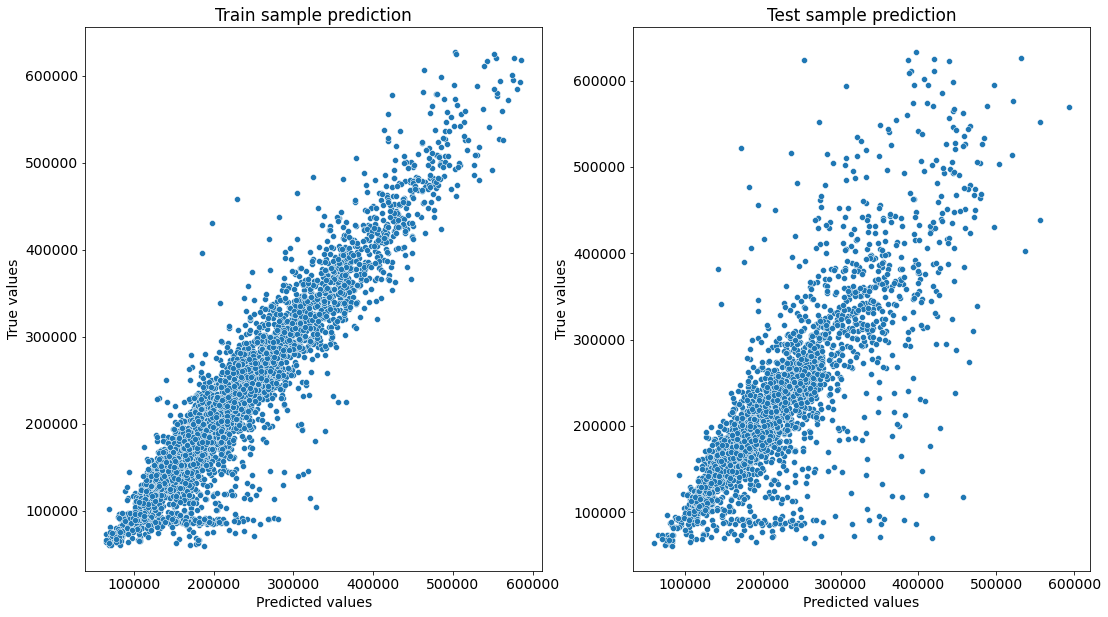

In [80]:
y_train_preds = lgbm_regressor_model.predict(X_train)
y_test_preds = lgbm_regressor_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [81]:
cv_score = cross_val_score(lgbm_regressor_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74266214, 0.76975864, 0.77081145])

In [82]:
cv_score.mean()

0.7610774119753523

Важность признаков

In [83]:
feature_importances = pd.DataFrame(zip(X_train.columns, lgbm_regressor_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,514
23,MedPriceByDistrict,331
6,HouseYear,273
7,Ecology_1,221
2,LifeSquare,213
5,HouseFloor,209
20,DistrictSize,197
3,KitchenSquare,166
12,Social_3,157
4,Floor,133


# Прогнозирование на тестовом датасете

In [84]:
test_df.shape

(5000, 25)

In [85]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,0,70.0,0,0,167155.991565,189145.451091
1,1.0,61.231434,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,164.0,0,1,128808.353899,172652.431537
2,2.0,59.463678,29.793435,9.0,19,19.0,1977,0.211401,1,1,...,1,0,0,0,0,568.0,0,1,164457.432677,174687.566186
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,0,375.0,0,1,157606.065847,180646.782352
4,1.0,53.837056,34.114505,3.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,0,76.0,0,0,162138.526832,189642.593314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,1,5.0,1962,0.069660,1,1,...,1,0,1,0,0,59.0,0,0,182289.757727,180646.782352
4996,3.0,93.698122,32.546002,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,25.0,0,0,419315.944641,212858.111162
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,0,0,0,0,69.0,0,0,148430.871401,180646.782352
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,1,0,0,0,0,35.0,0,0,166024.537530,189642.593314


In [86]:
submit = pd.read_csv(r'C:\Users\aermo\sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [87]:
predictions = lgbm_regressor_model.predict(test_df)
predictions

array([160327.45347766, 177361.2139919 , 139867.34381976, ...,
       146637.46152206, 168771.09832666, 261183.79060564])

In [88]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160327.453478
1,5925,177361.213992
2,960,139867.343820
3,3848,123768.926012
4,746,184061.910153


In [89]:
submit.to_csv('rf_submit.csv', index=False)